# Univariate Time Series Forecasting- Case Study

**About the Dataset:**
    
We have used a dataset which has the sales details on the tractor over 10 years of time.<br>

**Goal**

Since this case study only about the "Univariate Time Series Forecasting",we will be considering the variable "Number of Tractor Sold" for the forecasting purspose over the given period of time to forecast for 1 more year in the future.

**Methodology**

1. Exploratory Data Analysis
2. Applying different modelling techniques(Exponential Smoothing, ARMA, ARIMA, SARIMA)
3. Identifying the appropriate model wrt RMSE and MAPE
4. Fitting the entire dataset for the best model to forecast data for 1 year in the future.

## Import the required python libraries

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from datetime import  datetime,timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
plt.rcParams["figure.figsize"]=[15,7]

## Explanatory Data Analysis

In [209]:
# Reading the data and printing the head and tail to see the range of the date.

df=pd.read_csv("Data_sales_tractors.csv")
df.head()

,Month-Year,Number of Tractor Sold
0,3-Jan,141
1,3-Feb,157
2,3-Mar,185
3,3-Apr,199
4,3-May,203


In [210]:
df.tail()

,Month-Year,Number of Tractor Sold
139,14-Aug,848
140,14-Sep,640
141,14-Oct,581
142,14-Nov,519
143,14-Dec,605


**Observation:** Data is from January 2003 to December 2014.

In [211]:
df.shape

(144, 2)

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


**Observation:** Dataset has 144 records and 2 variables. Also, " Month-Year" its not in the datetime format.

In [213]:
# Statistical summary or five-pint summary

df.describe()

,Number of Tractor Sold
count,144.000000
mean,389.694444
std,171.500016
min,138.000000
25%,248.500000
50%,369.000000
75%,509.250000
max,871.000000


**Observation:** Avg. number of tractors sold are 390 with a standard deviation of 171 and the highest number of tractors sold in a month is 871.

In [214]:
# Missing values check

df.isna().sum()

Month-Year                0
Number of Tractor Sold    0
dtype: int64

**Observation:** No missing values found.

**What's Next?**<br>
1. Let us try to do some feature engineering to get the "Month-Year" in datetime format using date_range function.
2. Renaming the new feature as "TimeStamp".
3. Rename the feature "Number of Tractor Sold" to "Sales" for ease of use.
4. Check the head and tail to confirm the changes.

In [215]:
df["TimeStamp"]=pd.date_range(start="01/01/2004",periods=144,freq="M")

In [216]:
df.drop("Month-Year",axis=1,inplace=True)

In [217]:
df.set_index("TimeStamp",inplace=True)

In [218]:
df.columns=["Sales"]

In [219]:
df.head()

,Sales
TimeStamp,
2004-01-31,141
2004-02-29,157
2004-03-31,185
2004-04-30,199
2004-05-31,203


In [220]:
df.tail()

,Sales
TimeStamp,
2015-08-31,848
2015-09-30,640
2015-10-31,581
2015-11-30,519
2015-12-31,605


## Visualizations

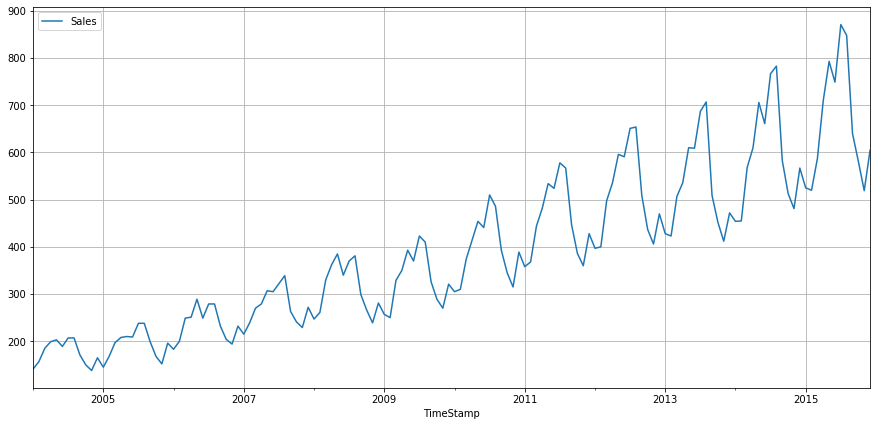

In [221]:
df.plot()
plt.grid()
plt.show()

**Observation**: The above plot hints us sbout the presence of trend and seasonality. We will confirm this in the decomposition plots as well.

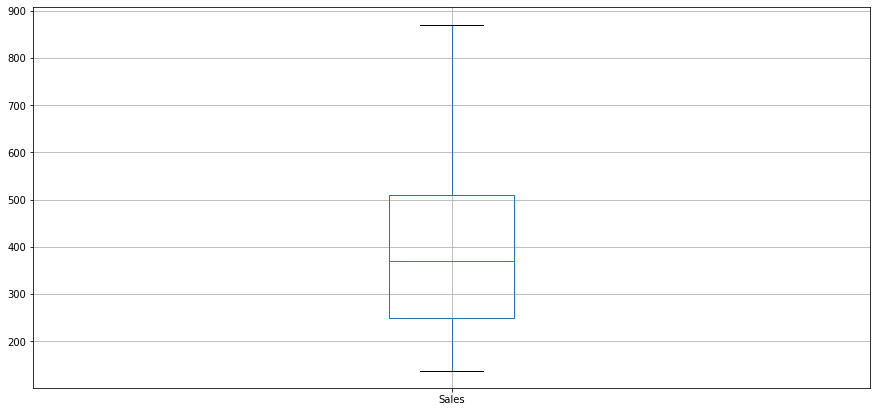

In [222]:
df.boxplot()
plt.show()

**Observation:** The boxplot shows there are no outliers present in the dataset.

Sales    0.635928
dtype: float64


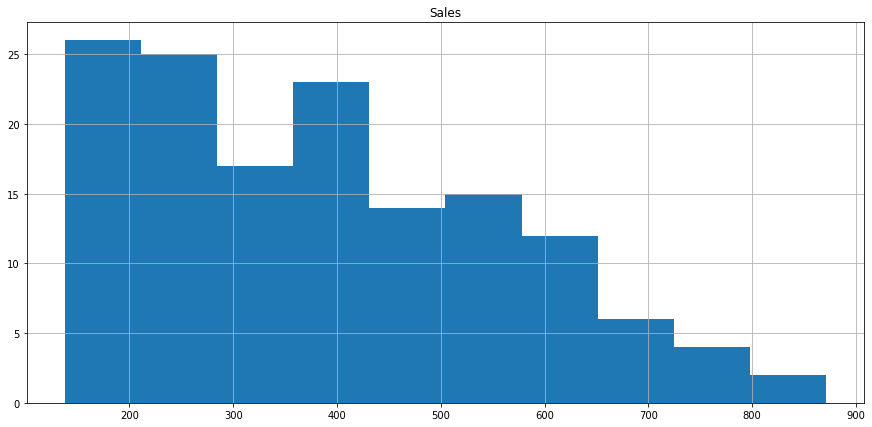

In [223]:
print(df.skew())
df.hist()
plt.show()

**Observation**: The Sales feature is slightly right skewed as the above distribution plot tails to the right side.

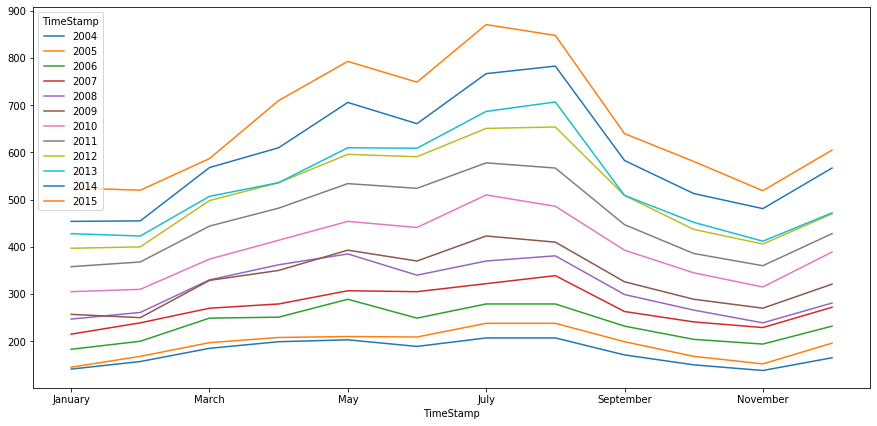

In [224]:
pi=pd.pivot_table(df,values="Sales",index=df.index.month_name(),columns=df.index.year)
months=["January","February","March","April","May","June","July","August","September","October","November","December"]
pi=pi.reindex(index=months)
pi.plot(figsize=(15,7))
plt.show()

**Observation:** Above plot confirms that there is seasonal peak in the sale of tractors during the month of July & August all throught the years.

## Decomposition

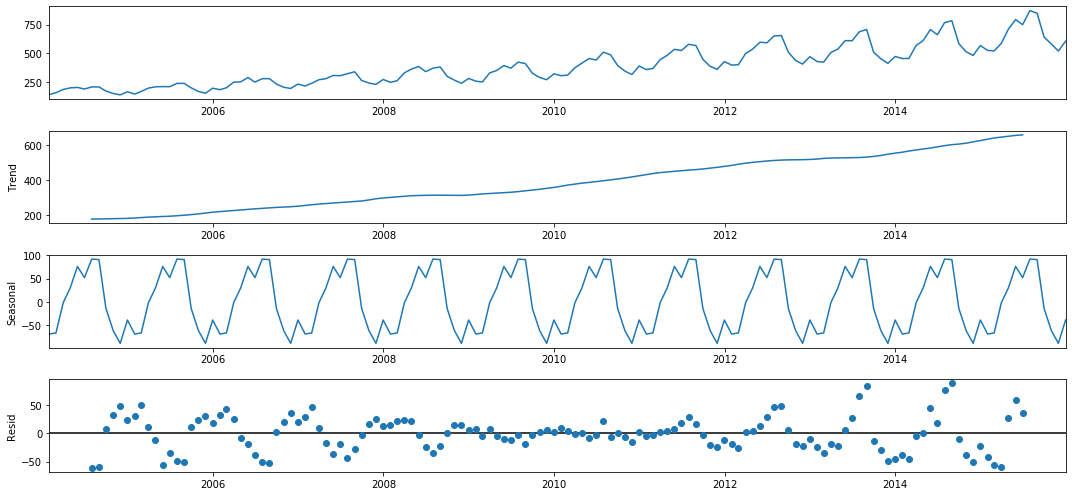

In [225]:
# Additive Decomposition
seasonal_decompose(df,model="additive").plot();

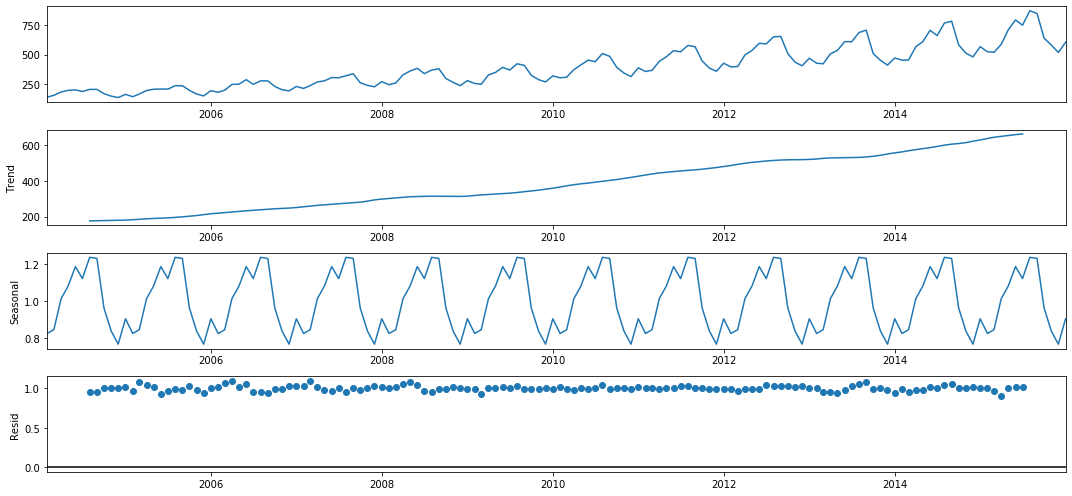

In [226]:
# Multiplicative Decomposition
seasonal_decompose(df,model="multiplicative").plot();

**Insights from both the decompositions on the components of time series forecasting:**

1. Trend-Linear(MUltiplicative)
2. Seasonality-Additive
3. Enitre Time Series data is "MUltipliative" as the residuals in multiplicative is more tightly spread than the additive method.

## Train-Test Split

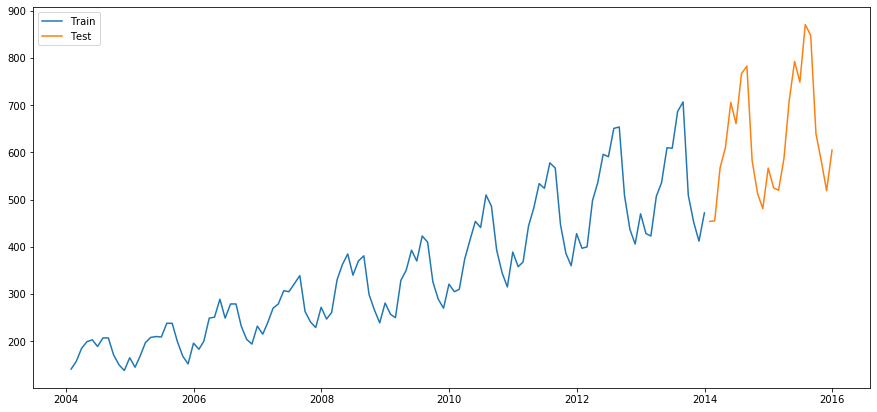

In [227]:
# We have considered 2 seasons to test.

train_end=datetime(2013,12,31)
test_end=datetime(2015,12,31)
train=df[:train_end]
test=df[train_end+timedelta(days=1):test_end]

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.legend()
plt.show()

In [228]:
df.shape[0],train.shape[0]+test.shape[0]

(144, 144)

**Observation:** Above shape confirms that the train-test split has not lost any records as the number of records matches with the original count 144.

## User-defined function to capture the RMSE and MAPE for each model

In [229]:
score_card=pd.DataFrame(columns=["Model","RMSE","MAPE"])
def update_score_card(name,actual,predicted):
    global score_card
    score_card=score_card.append({"Model":name,
                                  "RMSE":rmse(actual,predicted),
                                  "MAPE": (np.mean(np.abs((actual-predicted)/actual))*100)},ignore_index=True)
    return score_card

In [230]:
# score_card created successfully
score_card

,Model,RMSE,MAPE


## 1) Simple Exponential Smoothing(SES)

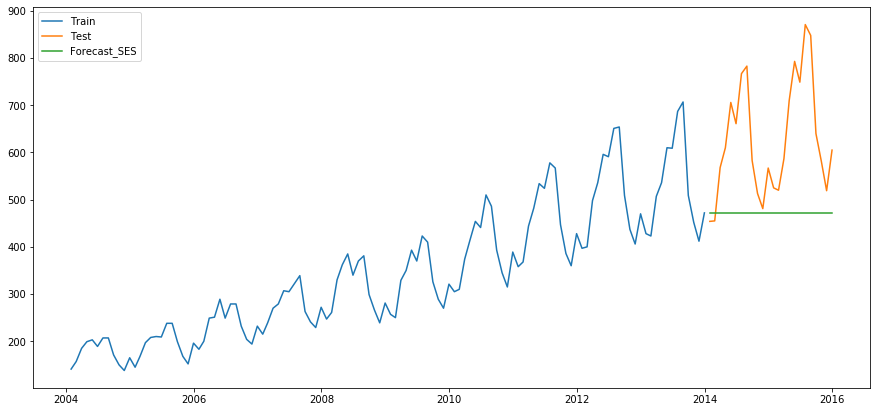

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147


In [231]:
SES=SimpleExpSmoothing(train,initialization_method="estimated")
model_SES=SES.fit(optimized=True)
SES_forecast=model_SES.forecast(steps=len(test))

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,SES_forecast,label="Forecast_SES")
plt.legend()
plt.show()

update_score_card("Simple Exponential Smoothing(SES)",test["Sales"],SES_forecast)

## 2) Double Exponential Smoothing(DES)

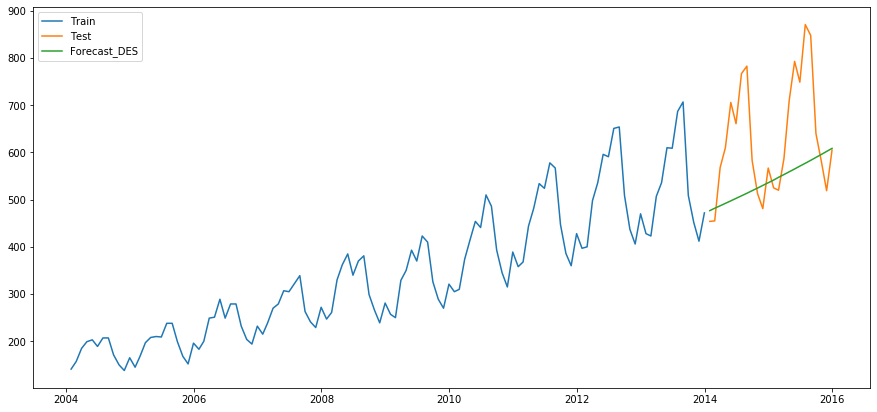

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147
1,Double Exponential Smoothing(DES),146.077152,15.626263


In [232]:
DES=Holt(train,exponential=True,initialization_method="estimated")
model_DES=DES.fit(optimized=True)
DES_forecast=model_DES.forecast(steps=len(test))

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,DES_forecast,label="Forecast_DES")
plt.legend()
plt.show()

update_score_card("Double Exponential Smoothing(DES)",test["Sales"],DES_forecast)

## 3) Triple Exponential Smoothing(TES)

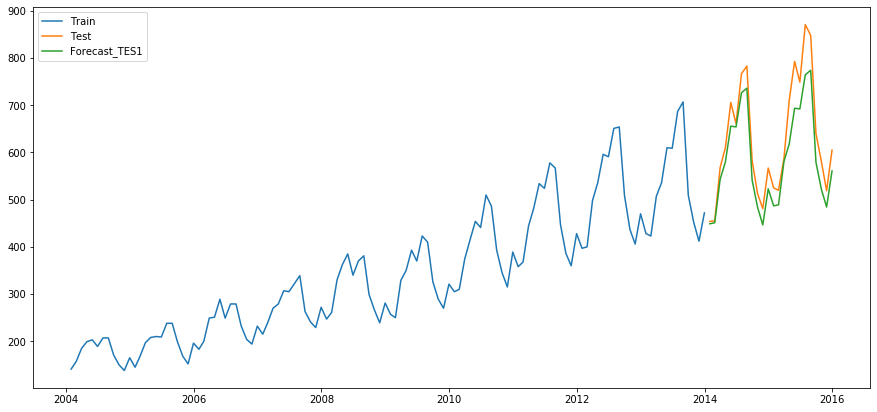

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147
1,Double Exponential Smoothing(DES),146.077152,15.626263
2,"TES(T=add,S=add)",51.952837,6.677072


In [233]:
# Model A: trend="add",seasonal="add"

TES1=ExponentialSmoothing(train,trend="add",seasonal="add",initialization_method="estimated")
model_TES1=TES1.fit(optimized=True)
TES1_forecast=model_TES1.forecast(steps=len(test))

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,TES1_forecast,label="Forecast_TES1")
plt.legend()
plt.show()

update_score_card("TES(T=add,S=add)",test["Sales"],TES1_forecast)

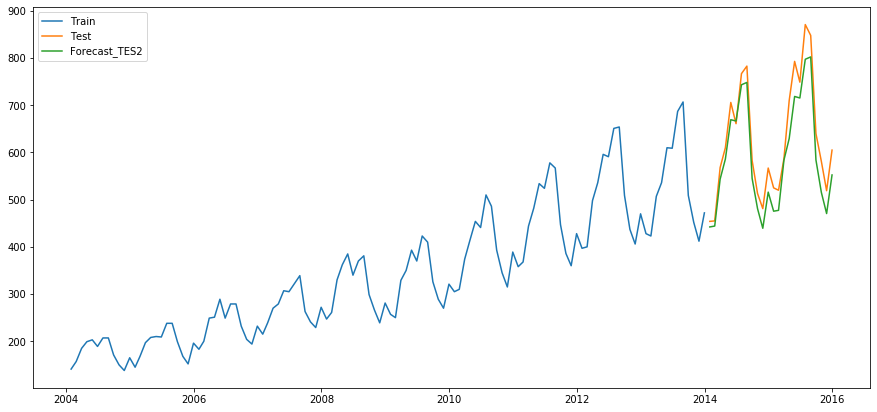

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147
1,Double Exponential Smoothing(DES),146.077152,15.626263
2,"TES(T=add,S=add)",51.952837,6.677072
3,"TES(T=add,S=mul)",45.098983,6.350625


In [234]:
# Model B: trend="add",seasonal="mul"

TES2=ExponentialSmoothing(train,trend="add",seasonal="mul",initialization_method="estimated")
model_TES2=TES2.fit(optimized=True)
TES2_forecast=model_TES2.forecast(steps=len(test))

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,TES2_forecast,label="Forecast_TES2")
plt.legend()
plt.show()

update_score_card("TES(T=add,S=mul)",test["Sales"],TES2_forecast)

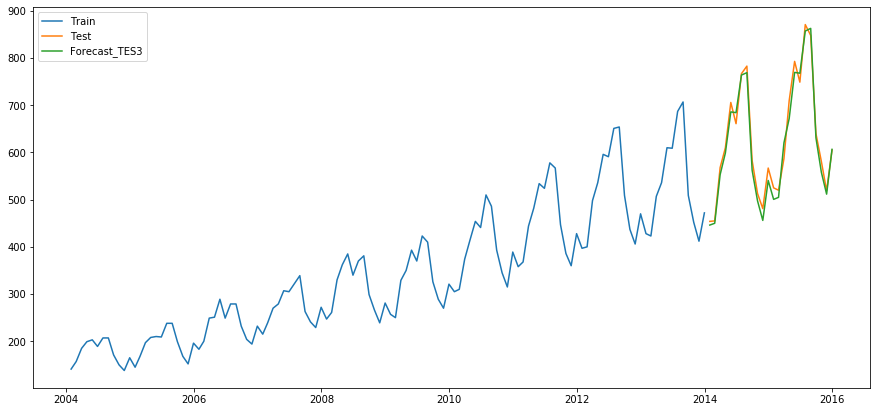

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147
1,Double Exponential Smoothing(DES),146.077152,15.626263
2,"TES(T=add,S=add)",51.952837,6.677072
3,"TES(T=add,S=mul)",45.098983,6.350625
4,"TES(T=mul,S=mul)",19.311384,2.781152


In [235]:
# Model C: trend="mul",seasonal="mul"

TES3=ExponentialSmoothing(train,trend="mul",seasonal="mul",initialization_method="estimated")
model_TES3=TES3.fit(optimized=True)
TES3_forecast=model_TES3.forecast(steps=len(test))

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,TES3_forecast,label="Forecast_TES3")
plt.legend()
plt.show()

update_score_card("TES(T=mul,S=mul)",test["Sales"],TES3_forecast)

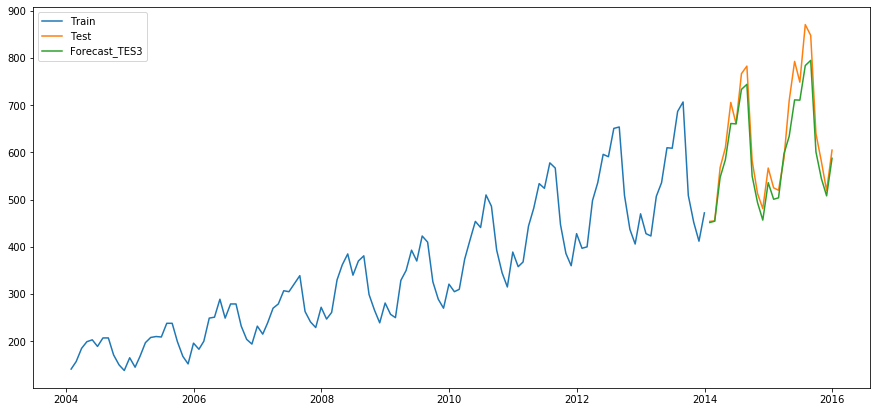

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147
1,Double Exponential Smoothing(DES),146.077152,15.626263
2,"TES(T=add,S=add)",51.952837,6.677072
3,"TES(T=add,S=mul)",45.098983,6.350625
4,"TES(T=mul,S=mul)",19.311384,2.781152
5,"TES(T=mul,S=add)",39.265971,4.704615


In [236]:
# Model D:trend="mul",seasonal="add" 

TES4=ExponentialSmoothing(train,trend="mul",seasonal="add",initialization_method="estimated")
model_TES4=TES4.fit(optimized=True)
TES4_forecast=model_TES4.forecast(steps=len(test))

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,TES4_forecast,label="Forecast_TES3")
plt.legend()
plt.show()

update_score_card("TES(T=mul,S=add)",test["Sales"],TES4_forecast)

## 4) ARMA

In [238]:
# Stationarity check using ADFuller test

check=adfuller(df.values)
check

(1.1088250591467386,
 0.995291241524842,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1082.5357724796872)

**Observation:** pvalue=0.99 which is !< 0.05,not stationary. Go for differencing d=1 and check again.

In [239]:
# Differencing 1st time for periods=1

diff1=df.diff().dropna()
check=adfuller(diff1.values)
check

(-2.5434807731960336,
 0.1052501261827321,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 1067.8217204928187)

**Observation:** pvalue=0.1 which is !< 0.05,not stationary. Go for differencing d=2 and check again

In [240]:
# Differencing 2st time for periods=1

diff2=diff1.diff().dropna()
check=adfuller(diff2.values)
check

(-8.63925736742353,
 5.4825446007072597e-14,
 13,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 1065.3703006406179)

**Insights:**

After 2 times of differencing, the TS became Stationary.<br>
Now feed the diff2 data to ARMA model.

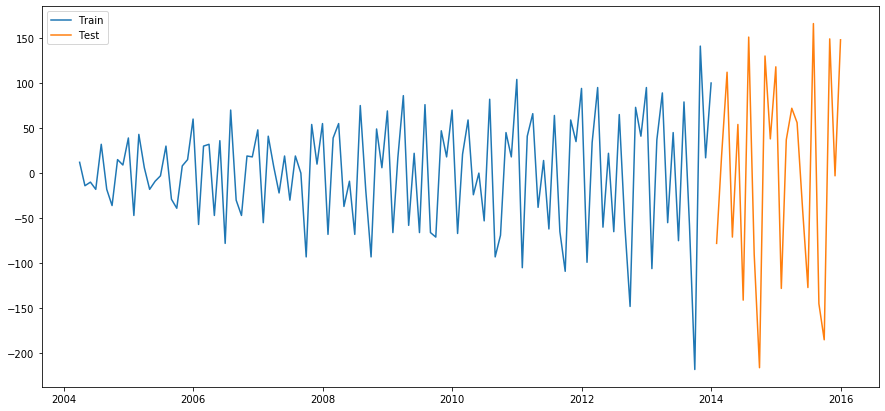

In [241]:
# Splitting again for train-test on the diff2 data.

train_end=datetime(2013,12,31)
test_end=datetime(2015,12,31)
train=diff2[:train_end]
test=diff2[train_end+timedelta(days=1):test_end]

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.legend()
plt.show()

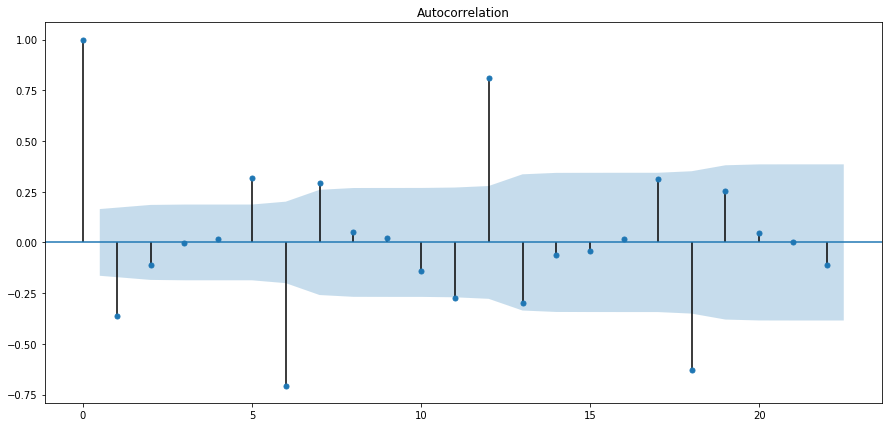

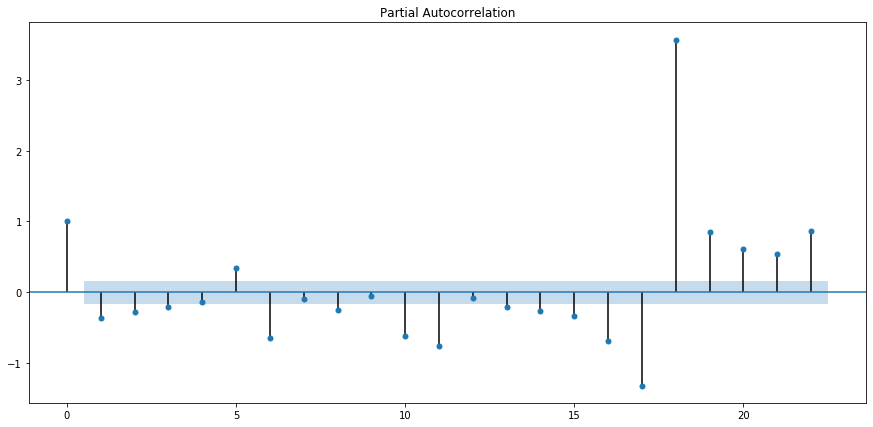

In [242]:
# Plotting the acf and pacf plots to observe "p" and "q" order values.

plot_acf(diff2);plot_pacf(diff2);plt.show()

**Observation:** For p=q=1 the initial cutoff happens. But, we do see lags significant at higher order. For ARMA, we will not consider the higherorder lags as they will be explained well in SARIMA.

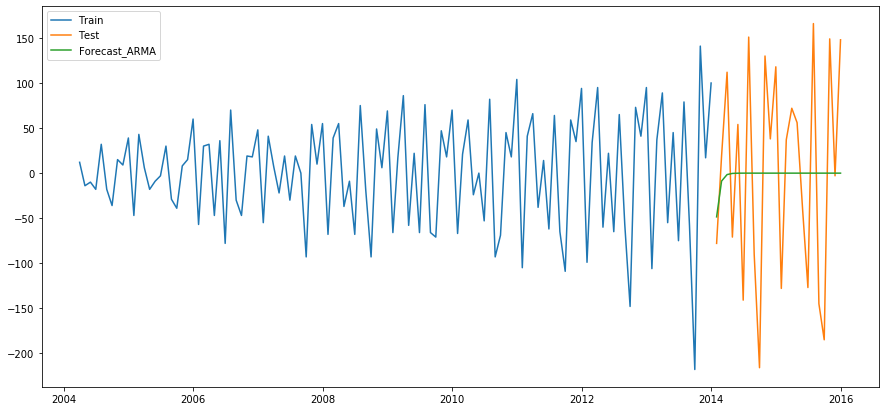

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147
1,Double Exponential Smoothing(DES),146.077152,15.626263
2,"TES(T=add,S=add)",51.952837,6.677072
3,"TES(T=add,S=mul)",45.098983,6.350625
4,"TES(T=mul,S=mul)",19.311384,2.781152
5,"TES(T=mul,S=add)",39.265971,4.704615
6,"ARMA(1,1)",115.991251,99.356590


In [243]:
# Fitting and forecasting for p=q=1(ARMA)

arma=ARMA(train,(1,1))
arma_model=arma.fit()
arma_forecast=arma_model.forecast(steps=len(test))[0]

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,arma_forecast,label="Forecast_ARMA")
plt.legend()
plt.show()

update_score_card("ARMA(1,1)",test["Sales"],arma_forecast)

## 5) ARIMA

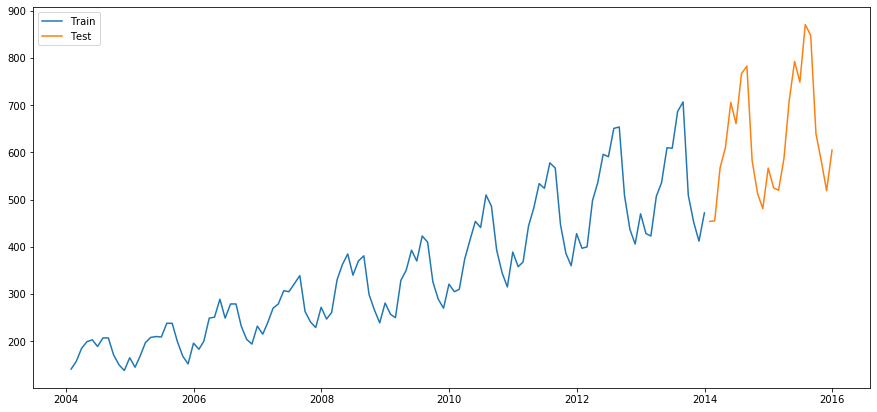

In [244]:
# Splitting again for train-test on the original data df.

train_end=datetime(2013,12,31)
test_end=datetime(2015,12,31)
train=df[:train_end]
test=df[train_end+timedelta(days=1):test_end]

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.legend()
plt.show()

In [245]:
# Find the best p,d,q values explaining least AIC and maximum Likelihood. Capture it in "aic_score" dataframe

import itertools
p=q=range(0,4)
d=range(1,3)
pq=list(itertools.product(p,d,q))
aic_score=pd.DataFrame(columns=["Combination","AIC"])
for i in pq:
    try:
        arima=ARIMA(train,order=i)
        model_arima=arima.fit()
        aic_score=aic_score.append({"Combination":i,"AIC":model_arima.aic},ignore_index=True)
        aic_score.sort_values(by="AIC",inplace=True)
    except:
        continue

In [246]:
aic_score.head()

,Combination,AIC
0,"(2, 1, 2)",1203.723640
1,"(3, 1, 3)",1213.541089
2,"(2, 1, 3)",1222.222306
3,"(1, 1, 3)",1224.623699
29,"(3, 2, 3)",1225.120536


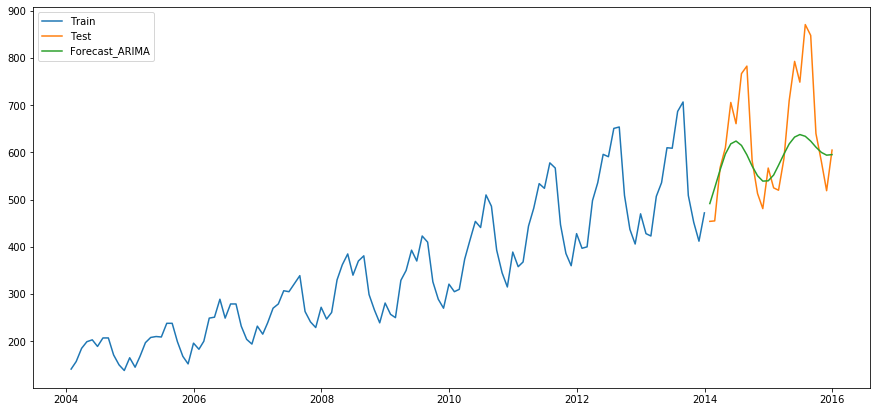

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147
1,Double Exponential Smoothing(DES),146.077152,15.626263
2,"TES(T=add,S=add)",51.952837,6.677072
3,"TES(T=add,S=mul)",45.098983,6.350625
4,"TES(T=mul,S=mul)",19.311384,2.781152
5,"TES(T=mul,S=add)",39.265971,4.704615
6,"ARMA(1,1)",115.991251,99.356590
7,"ARIMA(2,1,2)",100.617850,10.718979


In [247]:
# Fitting and forecasting for the least AIC p,d,q = (2,1,2)

arima=ARIMA(train,order=(2, 1, 2))
model_arima=arima.fit()
arima_forecast=model_arima.forecast(steps=len(test))[0]

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,arima_forecast,label="Forecast_ARIMA")
plt.legend()
plt.show()

update_score_card("ARIMA(2,1,2)",test["Sales"],arima_forecast)

## 6) SARIMA

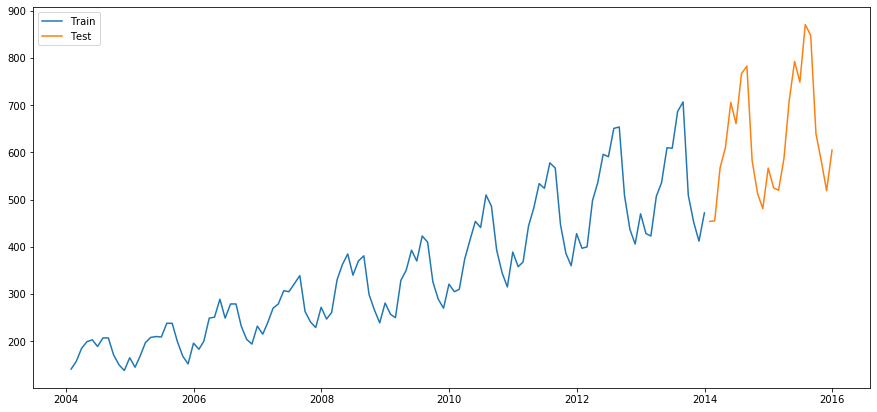

In [248]:
# Splitting again for train-test on the original data df.

train_end=datetime(2013,12,31)
test_end=datetime(2015,12,31)
train=df[:train_end]
test=df[train_end+timedelta(days=1):test_end]

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.legend()
plt.show()

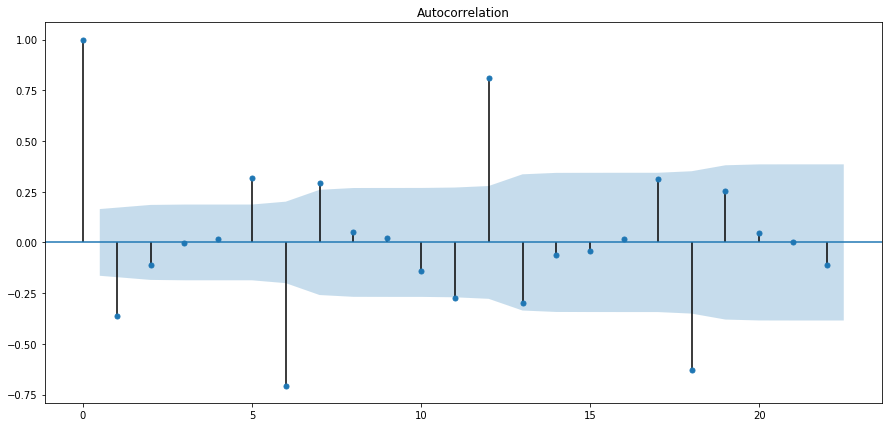

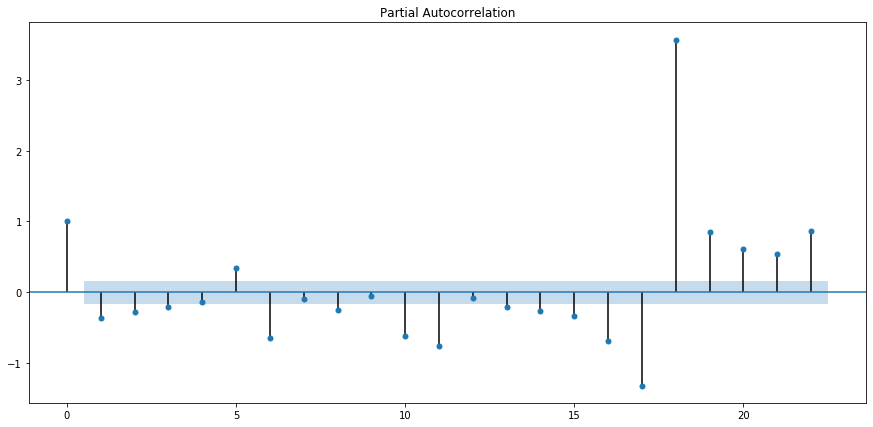

In [249]:
# Plotting the acf and pacf plots to observe "p","q" and seasonaity order values.

plot_acf(diff2);plot_pacf(diff2);plt.show()

**Observation:** We see there are significant lags in the higher order. From acf plot, at lag 12 there is significant explanation see. Hence, we can say that there is a seasonal impact for this time series.

In [131]:
# Find the best p,d,q and seasonal componentsvalues explaining least AIC and maximum Likelihood.
# Capture it in "aic_score" dataframe

import itertools
p=q=range(0,3)
d=range(1,2)
pq=list(itertools.product(p,d,q))
pq_sa=[(x[0],x[1],x[2],12) for x in pq]
aic_score=pd.DataFrame(columns=["params","seasonal","AIC"])
for i in pq:
    for j in pq_sa:
        sarima=SARIMAX(train,order=i,seasonal_order=j,enforce_stationarity=False,enforce_invertibility=False)
        model_sarima=sarima.fit()
        aic_score=aic_score.append({"params":i,"seasonal":j,"AIC":model_sarima.aic},ignore_index=True)       

In [132]:
aic_score.sort_values(by="AIC",inplace=True)

In [133]:
aic_score.head()

,params,seasonal,AIC
23,"(0, 1, 2)","(1, 1, 2, 12)",669.011798
26,"(0, 1, 2)","(2, 1, 2, 12)",670.022514
50,"(1, 1, 2)","(1, 1, 2, 12)",670.971042
53,"(1, 1, 2)","(2, 1, 2, 12)",671.772846
80,"(2, 1, 2)","(2, 1, 2, 12)",673.046630


In [250]:
# After a manual retuning from the above least AIC value, we got a further more least MAPE result at (1,0,1)(1,0,1,12).

sarima=SARIMAX(train,order=(1,0,1),
               seasonal_order=(1,0,1,12),
               enforce_stationarity=False,
               enforce_invertibility=False)
model_sarima=sarima.fit()
sarima_forecast=model_sarima.forecast(steps=len(test))

In [251]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100
mape=MAPE(test['Sales'].values,sarima_forecast.values)
print(mape)

3.2006581944064


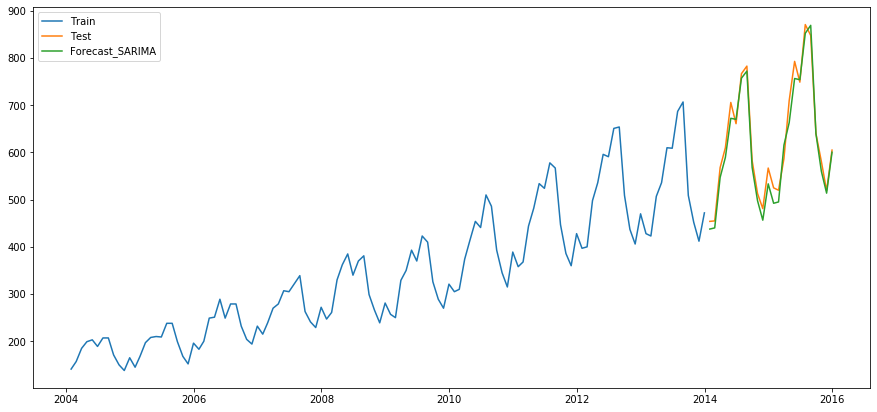

,Model,RMSE,MAPE
0,Simple Exponential Smoothing(SES),198.304412,22.909147
1,Double Exponential Smoothing(DES),146.077152,15.626263
2,"TES(T=add,S=add)",51.952837,6.677072
3,"TES(T=add,S=mul)",45.098983,6.350625
4,"TES(T=mul,S=mul)",19.311384,2.781152
5,"TES(T=mul,S=add)",39.265971,4.704615
6,"ARMA(1,1)",115.991251,99.356590
7,"ARIMA(2,1,2)",100.617850,10.718979
8,"SARIMA(1,0,1),(1,0,1,12)",22.572305,3.200658


In [252]:
#forecasting

plt.plot(train,label="Train")
plt.plot(test,label="Test")
plt.plot(test.index,sarima_forecast,label="Forecast_SARIMA")
plt.legend()
plt.show()

update_score_card("SARIMA(1,0,1),(1,0,1,12)",test["Sales"],sarima_forecast)

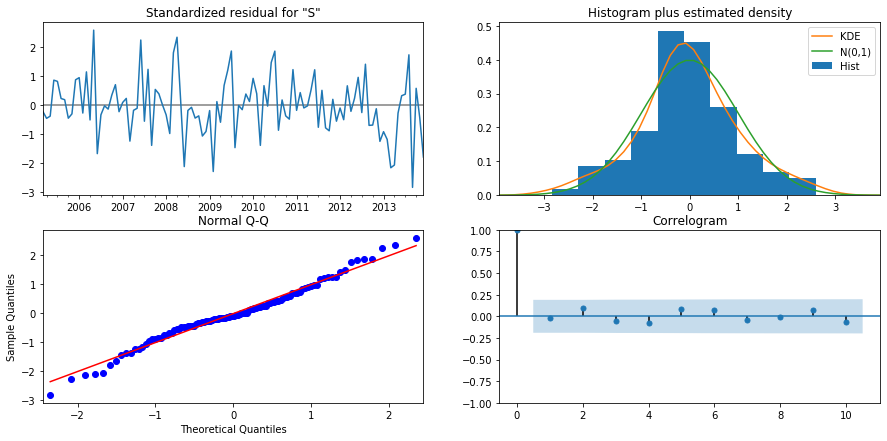

In [253]:
#Diagnostic plot to check the residual and other components

model_sarima.plot_diagnostics();

**Observation:** The residual plot shows least divergence from the reference line. It shows the error is normally distributed.

# Final ScoreCard

Sorting the score card with the least error(RMSE,MAPE). Then, build full model to forecast for 12 months in the future.

In [254]:
score_card.sort_values(by="MAPE")

,Model,RMSE,MAPE
4,"TES(T=mul,S=mul)",19.311384,2.781152
8,"SARIMA(1,0,1),(1,0,1,12)",22.572305,3.200658
5,"TES(T=mul,S=add)",39.265971,4.704615
3,"TES(T=add,S=mul)",45.098983,6.350625
2,"TES(T=add,S=add)",51.952837,6.677072
7,"ARIMA(2,1,2)",100.617850,10.718979
1,Double Exponential Smoothing(DES),146.077152,15.626263
0,Simple Exponential Smoothing(SES),198.304412,22.909147
6,"ARMA(1,1)",115.991251,99.356590


# Final Forecast on the entire dataset

We will bulid full model for the TES(T=mul,S=mul) and SARIMA(1,0,1),(1,0,1,12) as showed MAPE < 5%.

### 1.TES(T=mul,S=mul)

In [256]:
# Buliding a full model for the best MAPE

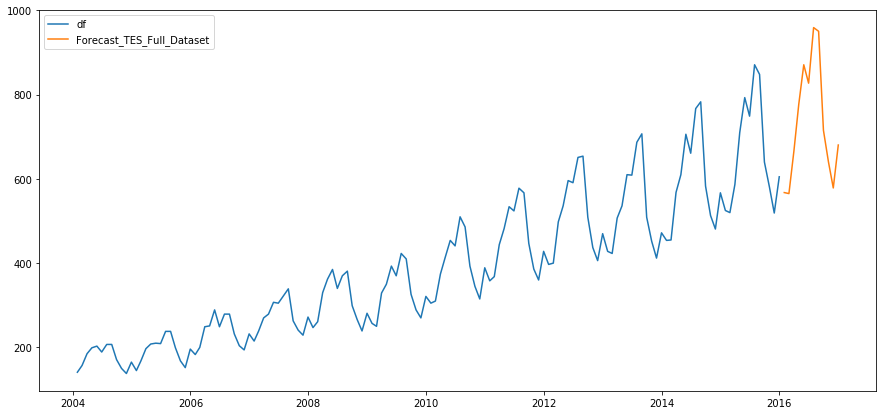

In [257]:
TES=ExponentialSmoothing(df,trend="mul",seasonal="mul",initialization_method="estimated")
model_TES=TES.fit(optimized=True)
TES_forecast=model_TES.forecast(steps=12)

plt.plot(df,label="df")
plt.plot(TES_forecast.index,TES_forecast,label="Forecast_TES_Full_Dataset")
plt.legend()
plt.show()

### 2. SARIMA

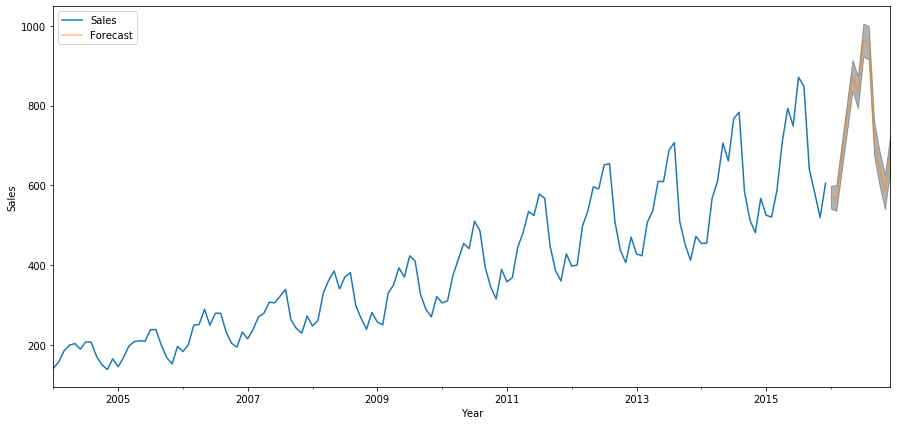

In [258]:
sarima=SARIMAX(df,order=(1,0,1),
               seasonal_order=(1,0,1,12),
               enforce_stationarity=False,
               enforce_invertibility=False)
model_sarima=sarima.fit()
sarima_forecast=model_sarima.forecast(steps=12)

pred95=model_sarima.get_forecast(steps=12)
pred95_conf=pred95.conf_int()

axis=df.plot(label='Actual Trens', figsize=(15, 7))
sarima_forecast.plot(ax=axis,label='Forecast', alpha=0.5)
axis.fill_between(sarima_forecast.index, pred95_conf['lower Sales'], pred95_conf['upper Sales'], color='k', alpha=.3)
axis.set_xlabel('Year')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()

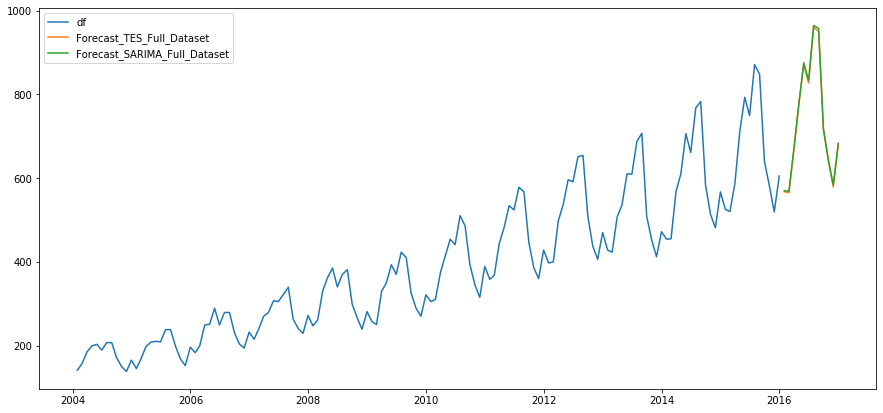

In [259]:
plt.rcParams["figure.figsize"]=[15,7]
plt.plot(df,label="df")
plt.plot(TES_forecast.index,TES_forecast,label="Forecast_TES_Full_Dataset")
plt.plot(sarima_forecast.index,sarima_forecast,label="Forecast_SARIMA_Full_Dataset")
plt.legend()
plt.show()

# END